### Load Modules

In [1]:
import sys, os
from tqdm import tqdm

path = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.insert(0, path+"\\.")
print('Please check the path below: \n')
print(path)

from src.data.get_satellite import *
from src.data.get_osm import *
from src.data.utils import *

Please check the path below: 

c:\Users\ucn\Education\20211\InnoLab\gather-project


### Configurations

In [2]:
country_code = 'MGD'
highway_types = ['primary', 'secondary', 'tertiary', 'unclassified', 'residential', 'road', 
                'track', 'motorway', 'trunk', 'living_street', 'motorway_link', 'trunk_link', 
                'primary_link', 'secondary_link','tertiary_link']

### Read Antananarivo Administrative level 2 boundaries

Data source: [The Humanitarian Data Exchange](https://data.humdata.org/dataset/madagascar-administrative-level-0-4-boundaries)

In [3]:
mgd_boundary = gp.read_file('../../data/mdg_adm_2')

**Filtering with the antananarivo area codes**

In [6]:
antananarivo_province = mgd_boundary[[i.startswith('MG1') for i in mgd_boundary.ADM1_PCODE]]
antananarivo_renivohitra = antananarivo_province[[i.startswith('MG1110100') for i in antananarivo_province.ADM2_PCODE]]
antananarivo_province.head()

,ADM0_PCODE,ADM0_EN,ADM1_PCODE,ADM1_EN,ADM1_TYPE,ADM2_PCODE,ADM2_EN,ADM2_TYPE,PROV_CODE,OLD_PROVIN,PROV_TYPE,NOTES,SOURCE,geometry
0,MG,Madagascar,MG11,Analamanga,Region,MG11101001A,1er Arrondissement,District,1,Antananarivo,Old Provinces/Faritany dissolved in 2007,Previous district name is Antananarivo Renivoh...,Note that Communes (admin 3) have become the D...,"POLYGON ((47.50556 -18.89146, 47.50563 -18.891..."
1,MG,Madagascar,MG11,Analamanga,Region,MG11101002A,2e Arrondissement,District,1,Antananarivo,Old Provinces/Faritany dissolved in 2007,Previous district name is Antananarivo Renivoh...,Note that Communes (admin 3) have become the D...,"POLYGON ((47.55842 -18.91178, 47.55857 -18.911..."
2,MG,Madagascar,MG11,Analamanga,Region,MG11101003A,3e Arrondissement,District,1,Antananarivo,Old Provinces/Faritany dissolved in 2007,Previous district name is Antananarivo Renivoh...,Note that Communes (admin 3) have become the D...,"POLYGON ((47.51365 -18.87834, 47.51775 -18.879..."
3,MG,Madagascar,MG11,Analamanga,Region,MG11101004A,4e Arrondissement,District,1,Antananarivo,Old Provinces/Faritany dissolved in 2007,Previous district name is Antananarivo Renivoh...,Note that Communes (admin 3) have become the D...,"POLYGON ((47.50262 -18.91043, 47.50261 -18.910..."
4,MG,Madagascar,MG11,Analamanga,Region,MG11101005A,5e Arrondissement,District,1,Antananarivo,Old Provinces/Faritany dissolved in 2007,Previous district name is Antananarivo Renivoh...,Note that Communes (admin 3) have become the D...,"POLYGON ((47.53500 -18.85464, 47.53518 -18.854..."


### Get OSM data

In [5]:
ways = get_ways(highway_types, country_code)
print('# of linestrings gathered: ' + str(len(ways)))

# of linestrings gathered: 157232


### Get grid of tiles for antananarivo

Creating grid of tiles...
Visualizing the grid...
Done!
Area of the polygon is 18.310813845178362 km^2


C:\Users\ucn\AppData\Local\Programs\Python\Python37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\ucn\AppData\Local\Programs\Python\Python37\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


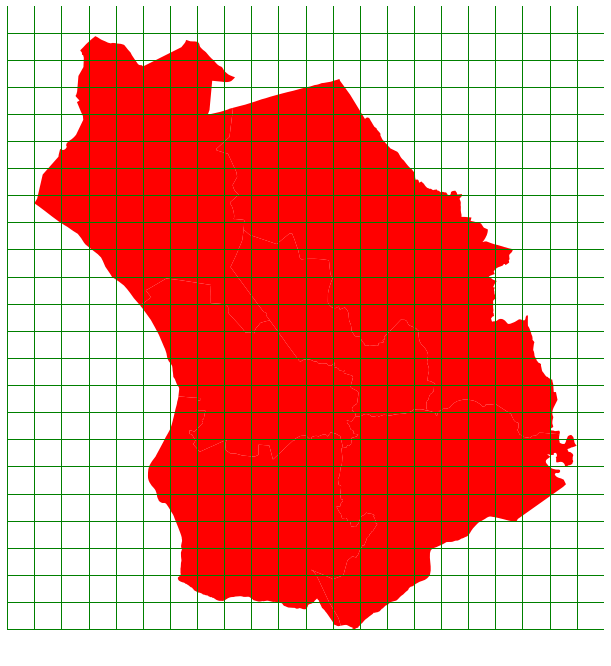

In [11]:
tiles = get_grid(antananarivo_renivohitra, 20)
tile_area = get_polygon_area_km(tiles['geometry'][0])

### Get the linestrings inside/crossing the antananarivo renivohitra tiles

C:\Users\ucn\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...

  """Entry point for launching an IPython kernel.


(47.444209055, 47.615972844999995, -18.984265915, -18.781524585)

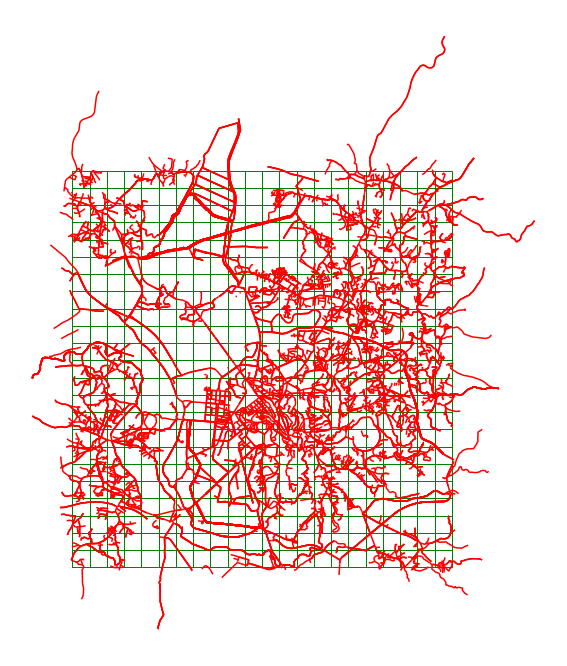

In [12]:
ant_ways = gp.sjoin(ways, tiles, how = 'inner', predicate = 'intersects')

ax = ant_ways.plot(markersize=.1, figsize=(18, 12), color='red')
plt.autoscale(False)
tiles.plot(ax=ax, facecolor="none", edgecolor='green')
ax.axis("off")

### Get images for the tiles

In [13]:
token = 'pk.eyJ1IjoidXRrdWNhbm96dHVyayIsImEiOiJja3F0Njdka28wNHkyMnZwOGs2OGV3aW81In0.HRXxTxlUy1C6DGfkTmNjOQ'
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

for tile in tqdm(range(len(tiles))):
    tile_x, tile_y = tiles['geometry'][tile].centroid.coords.xy
    # Define a map centered on the way
    map_ = folium.Map(location=[tile_y[0], tile_x[0]], zoom_start=18, tiles=tileurl, attr='Mapbox')

    for way in ant_ways['geom']:
        folium.PolyLine(reverse_coord(way), color = 'red', weight = 5, opacity = 1).add_to(map_)

    
    save_map_image(map_, '../../data/tiles_20_31Jan_18zoom/tile_' + str(tile) + '.png')

100%|██████████| 506/506 [3:01:46<00:00, 21.55s/it]  
